In [ ]:
import numpy as np

# 확인할 .npz 파일 경로를 지정하세요
file_path = 'submodule/CONDOR/src/datasets/LAIR/capricorn/capricorn_0.npy'

data = np.load(file_path, allow_pickle=True)

# 변수 목록 출력
print("Variables in .npz:")

# 변수별 메타정보와 값 출력
for name in data.files:
    arr = data[name]
    print(f"\n=== {name} ===")
    print(f"shape = {arr.shape}, dtype = {arr.dtype}")




Variables in .npz:


AttributeError: 'numpy.ndarray' object has no attribute 'files'

Data preprocessing, demonstration 1 / 7
Data preprocessing, demonstration 2 / 7
Data preprocessing, demonstration 3 / 7
Data preprocessing, demonstration 4 / 7
Data preprocessing, demonstration 5 / 7
Data preprocessing, demonstration 6 / 7
Data preprocessing, demonstration 7 / 7
Mean error spline resampling: 1.5672742771011574e-16
--- Output Data Keys ---
dict_keys(['demonstrations train', 'demonstrations raw', 'demonstrations primitive id', 'n primitives', 'delta t eval', 'x min', 'x max', 'goals', 'goals training', 'max demonstration length', 'demonstrations length', 'eval indexes', 'n demonstrations', 'vel min train', 'vel max train', 'acc min train', 'acc max train'])


/tmp/ipykernel_2208961/482659304.py:52: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


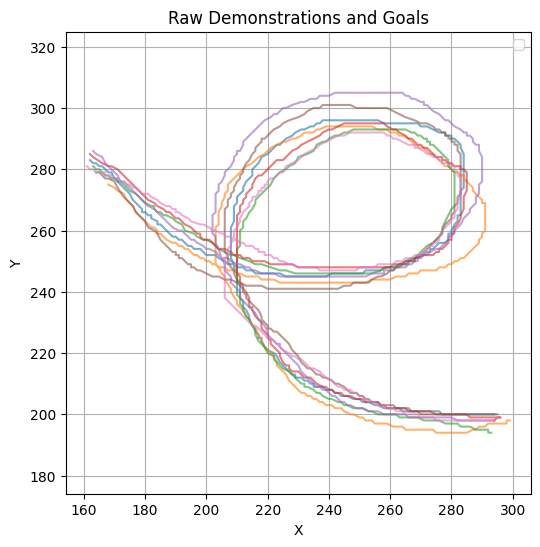

In [108]:
import os
import sys
base_dir = "C:/Users/user/Desktop/기시설/code"

src_path = os.path.join(base_dir, 'submodule', 'CONDOR', 'src')
sys.path.insert(0, src_path)
import matplotlib.pyplot as plt
from submodule.CONDOR.src.data_preprocessing.data_preprocessor import DataPreprocessor
from types import SimpleNamespace

# 1) Params 객체 정의 (필요한 필드만 간략히 작성)
params = SimpleNamespace(
    trajectories_resample_length=100,
    state_increment=0.1,
    workspace_dimensions=2,            # 2D
    dynamical_system_order=2,
    workspace_boundaries_type='from data',
    workspace_boundaries=[[0,0],[0,0]],# unused when 'from data'
    evaluation_samples_length=50,
    dataset_name='LAIR',
    selected_primitives_ids='0',     # 원하는 프리미티브 인덱스
    spline_sample_type='evenly spaced',
    imitation_window_size=20,
    verbose=False
)

# 2) 전처리 객체 생성 및 실행
preprocessor = DataPreprocessor(params)
output = preprocessor.run()

# 3) 원시 궤적과 목표점 가져오기
print("--- Output Data Keys ---")
print(output.keys()) # output 딕셔너리의 모든 키(데이터 이름)를 출력

raw_demos = output['demonstrations raw']       # list of arrays shape (2, T)
goals     = output['goals']                    # array shape (n_primitives, 2)

# 4) 시각화
plt.figure(figsize=(6,6))
for traj in raw_demos:
    x, y = traj[0], traj[1]
    plt.plot(x, y, alpha=0.6)
    

# 목표점은 붉은 X 마커로
# plt.scatter(goals[:,0], goals[:,1], c='r', marker='x', s=100, label='Goals')

plt.title('Raw Demonstrations and Goals')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')
plt.legend()
plt.grid(True)
plt.show()


In [109]:
print(output['demonstrations train'].shape)
print(output["demonstrations raw"][1].shape)

(7, 100, 2, 21)
(2, 287)


In [125]:
output['demonstrations train'][0,1,:,:]

array([[-0.85283662, -0.83966139, -0.82648616, -0.81331093, -0.8001357 ,
        -0.78696047, -0.77378524, -0.76061001, -0.74743478, -0.73425955,
        -0.72108432, -0.70790909, -0.69473386, -0.68155863, -0.67193676,
        -0.6683834 , -0.65520816, -0.64203293, -0.63241107, -0.62530434,
        -0.60606061],
       [ 0.51597052,  0.51155282,  0.4951728 ,  0.48321048,  0.47437509,
         0.44603275,  0.42965274,  0.41327272,  0.39689271,  0.38051269,
         0.35971498,  0.33137264,  0.31499262,  0.29861261,  0.28223259,
         0.27027027,  0.26585257,  0.25389025,  0.24947256,  0.23309254,
         0.21671253]])

In [130]:
window=output['demonstrations train'][0,0]
window[:,0]

array([-0.89591568,  0.54873055])

Avg Triplet Loss along trajectory: 1.804054
(200,)
(200,)
(200,)
(200,)


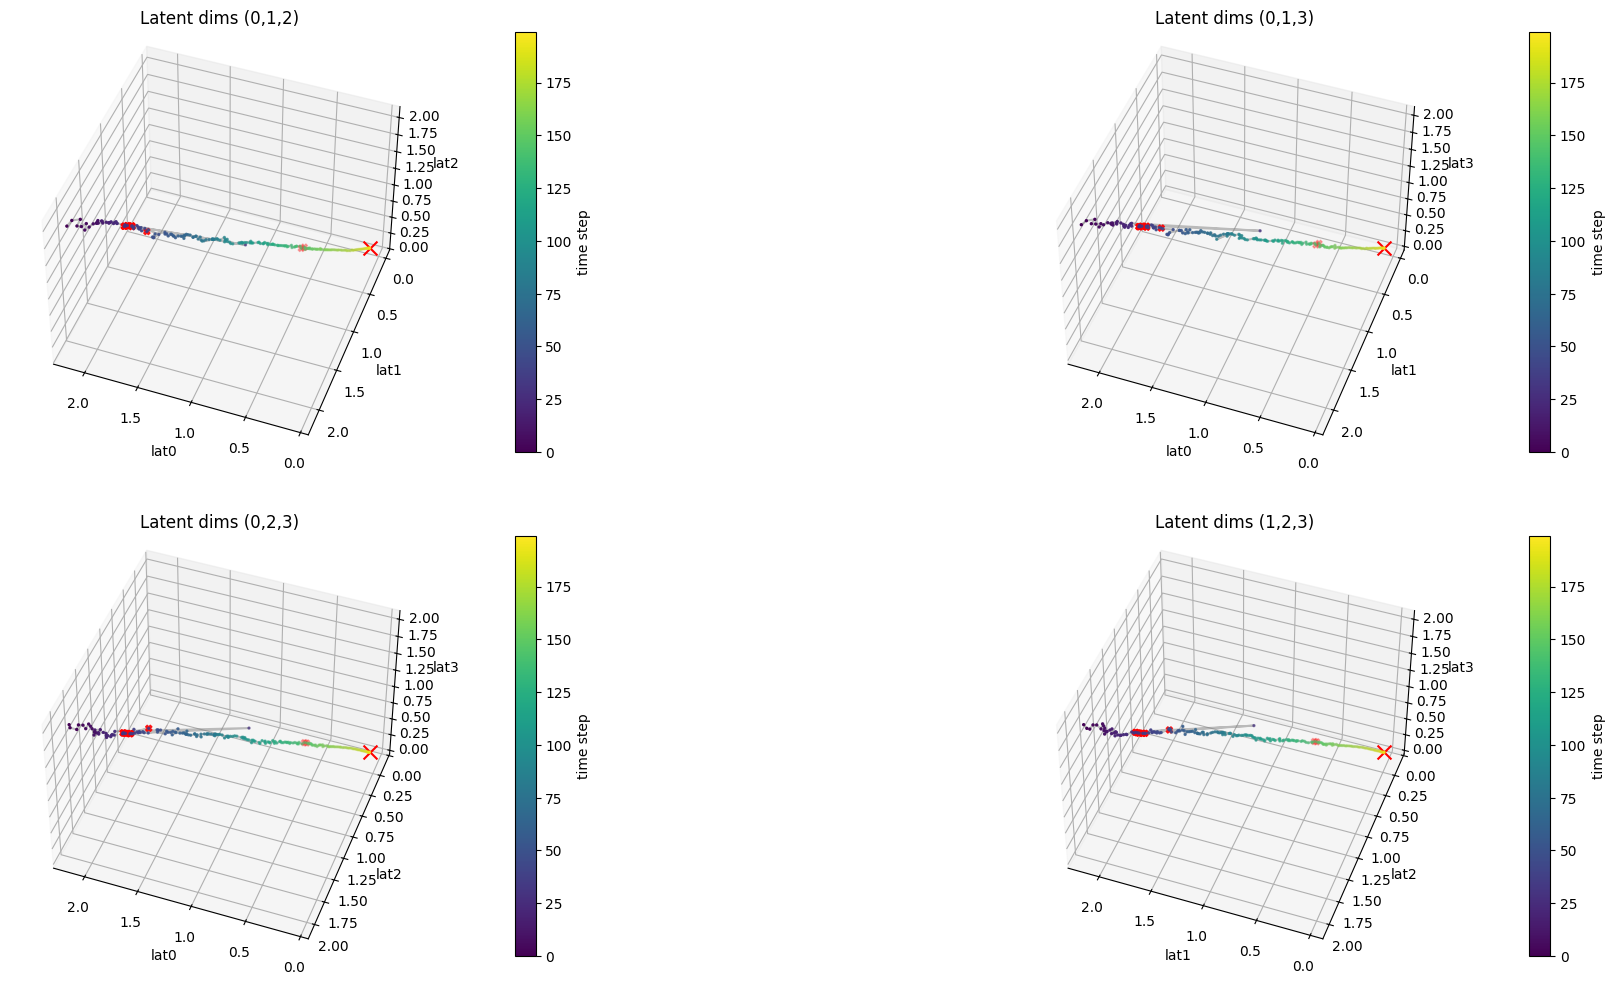

In [191]:
# %%
# Imports and setup
%matplotlib inline
import torch
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from mpl_toolkits.mplot3d import Axes3D
import sys
import os
base_dir = ""

src_path = os.path.join(base_dir, 'submodule', 'CONDOR', 'src')
sys.path.insert(0, src_path)

# Condor pipeline imports
from submodule.CONDOR.src.data_preprocessing.data_preprocessor import DataPreprocessor
from encoder import Encoder

# %%
# Define or import TrainParams (same as used during training)
@dataclass
class InferenceParams:
    workspace_dimensions: int = 2
    dynamical_system_order: int = 2
    dataset_name: str = "LAIR"
    selected_primitives_ids: str = "0"
    trajectories_resample_length: int = 200
    state_increment: float = 0.2
    workspace_boundaries_type: str = "from data"
    workspace_boundaries: tuple = ((-1, 1),) * 3
    spline_sample_type: str = "evenly spaced"
    evaluation_samples_length: int = 10
    imitation_window_size: int = 2
    triplet_margin = 1e-4

    latent_space_dim: int = 4
    hidden_size: int = 300

    device: str = "cpu"
    results_path: str = "results/"

params = InferenceParams()

# %%
# 1. Load and preprocess data
data = DataPreprocessor(params=params, verbose=False).run()
# Use training or test demonstrations
demos = data['demonstrations train']  # shape: (n_traj, n_steps, dim_ws, window)
primitive_ids = np.array(data['demonstrations primitive id'])
n_primitives = data['n primitives']

# %%
# 2. Load trained encoder
dim_state = params.workspace_dimensions * params.dynamical_system_order
device = params.device
encoder = Encoder(
    dim_state=dim_state,
    n_primitives=n_primitives,
    latent_space_dim=params.latent_space_dim,
    hidden_size=params.hidden_size,
    device=device
).to(device)

# Load weights (ignoring missing goal buffer)
checkpoint = torch.load(params.results_path + "ver8/encoder_triplet_ver8.pt", map_location=device)
encoder.load_state_dict(checkpoint, strict=False)
encoder.eval()

# %%
# 3. Encode a single demonstration in latent space
traj_idx = 0  # index of trajectory to visualize
demo = demos[traj_idx]  # shape: (n_steps, dim_ws, window)
n_steps, dim_ws, window = demo.shape

latent_traj = []
for t in range(n_steps):
    pos = demo[t, :, 0]  # (dim_ws,)
    if params.dynamical_system_order == 2:
        next_pos = demo[t, :, 1]
        vel = next_pos - pos
        from submodule.CONDOR.src.agent.utils.dynamical_system_operations import normalize_state
        vel_norm = normalize_state(
            torch.tensor(vel).view(1, dim_ws, 1),
            x_min=torch.tensor(data['vel min train']).view(1, dim_ws, 1),
            x_max=torch.tensor(data['vel max train']).view(1, dim_ws, 1)
        ).squeeze()
        state_vec = torch.cat([torch.tensor(pos), vel_norm], dim=0)
    else:
        state_vec = torch.tensor(pos)

    x_input = state_vec.view(1, -1).float().to(device)
    prim_tensor = torch.tensor([primitive_ids[traj_idx]], device=device)
    with torch.no_grad():
        lat = encoder(x_input, prim_tensor).cpu().numpy().squeeze()
    latent_traj.append(lat)

latent_traj = np.stack(latent_traj)  # shape: (n_steps, latent_space_dim)

# %%
# 3.5. Compute goal embedding on the fly
prim_id = primitive_ids[traj_idx]
goal_pos = data['goals training'][prim_id]   # (dim_ws,)

if params.dynamical_system_order == 2:
    zero_vel = np.zeros_like(goal_pos)
    from submodule.CONDOR.src.agent.utils.dynamical_system_operations import normalize_state
    vel_norm_goal = normalize_state(
        torch.tensor(zero_vel).view(1, dim_ws, 1),
        x_min=torch.tensor(data['vel min train']).view(1, dim_ws, 1),
        x_max=torch.tensor(data['vel max train']).view(1, dim_ws, 1)
    ).squeeze()
    x_goal = torch.cat([torch.tensor(goal_pos), vel_norm_goal], dim=0)
else:
    x_goal = torch.tensor(goal_pos)

x_goal = x_goal.view(1, -1).float().to(device)
prim_tensor = torch.tensor([prim_id], device=device)

with torch.no_grad():
    goal_lat = encoder(x_goal, prim_tensor).cpu().numpy().squeeze()  # (latent_space_dim,)
    
    


margin = params.triplet_margin if hasattr(params, 'triplet_margin') else 1.0
loss_fn = torch.nn.TripletMarginLoss(margin=margin, p=2)

# 텐서 변환
latents = torch.tensor(latent_traj, dtype=torch.float32)       # (n_steps, latent_dim)
goal = torch.tensor(goal_lat, dtype=torch.float32).unsqueeze(0) # (1, latent_dim)
# 반복: 마지막 스텝은 다음 스텝이 없으므로 n_steps-1까지만
losses = []
for t in range(latents.size(0) - 1):
    # viz 쪽
    anchor   = torch.tensor(goal_lat).unsqueeze(0)
    positive = latents[t+1].unsqueeze(0)
    negative = latents[t].unsqueeze(0)
    l = loss_fn(anchor, positive, negative)

    losses.append(l.item())

triplet_loss = float(np.sum(losses))
print(f"Avg Triplet Loss along trajectory: {triplet_loss:.6f}")

# %%
# 4. Plot 3D subplots including on-the-fly goal
combinations = [(0,1,2), (0,1,3), (0,2,3), (1,2,3)]
# 4. Plot 3D subplots with gradient color
fig = plt.figure(figsize=(24, 12))
t_idxs = np.arange(latent_traj.shape[0])  # 시간 인덱스 0,1,...,n_steps-1
special_idxs = [30,31,32,33,34,35, 143,144 ]
for i, (a,b,c) in enumerate(combinations, 1):
    ax = fig.add_subplot(2, 2, i, projection='3d')
    ax.plot(latent_traj[:, a], latent_traj[:, b], latent_traj[:, c],
            color='gray', alpha=0.5)
            
    sc = ax.scatter(
        latent_traj[:, a], latent_traj[:, b], latent_traj[:, c],
        c=t_idxs,           # 각 점에 색 지정
        cmap='viridis',     # matplotlib colormap
        s=2                # 점 크기
    )
    
    mask = np.isin(t_idxs, special_idxs)
    print(mask.shape,)
    ax.scatter(latent_traj[mask, a], latent_traj[mask, b], latent_traj[mask, c],
               c='red', marker='X', s=20, label='special points')
    
    ax.scatter(goal_lat[a], goal_lat[b], goal_lat[c],
               marker='x', s=100, c='red', label='goal')
    X = latent_traj[:-1, a]
    Y = latent_traj[:-1, b]
    Z = latent_traj[:-1, c]
    U = latent_traj[1:, a] - X
    V = latent_traj[1:, b] - Y
    W = latent_traj[1:, c] - Z
    # ax.quiver(X, Y, Z, U, V, W,
            #   length=0.001, normalize=True, color='red', linewidth=0.1)
    # 컬러바 추가
    fig.colorbar(sc, ax=ax, pad=0.1, label='time step')
    ax.set_xlabel(f'lat{a}')
    ax.set_ylabel(f'lat{b}')
    ax.set_zlabel(f'lat{c}')
    ax.set_title(f'Latent dims ({a},{b},{c})')
    ax.view_init(elev=45, azim=110)



In [132]:
traj_idx=[i for i in range(7)]
for i in traj_idx:
    demo = demos[i]  # shape: (n_steps, dim_ws, window)
    n_steps, dim_ws, window = demo.shape
    
    latent_traj = []
    for t in range(n_steps):
        pos = demo[t, :, 0]  # (dim_ws,)
        if params.dynamical_system_order == 2:
            next_pos = demo[t, :, 1]
            vel = next_pos - pos
            from submodule.CONDOR.src.agent.utils.dynamical_system_operations import normalize_state
            vel_norm = normalize_state(
                torch.tensor(vel).view(1, dim_ws, 1),
                x_min=torch.tensor(data['vel min train']).view(1, dim_ws, 1),
                x_max=torch.tensor(data['vel max train']).view(1, dim_ws, 1)
            ).squeeze()
            state_vec = torch.cat([torch.tensor(pos), vel_norm], dim=0)
        else:
            state_vec = torch.tensor(pos)
    
        x_input = state_vec.view(1, -1).float().to(device)
        prim_tensor = torch.tensor([primitive_ids[traj_idx]], device=device)
        with torch.no_grad():
            lat = encoder(x_input, prim_tensor).cpu().numpy().squeeze()
        latent_traj.append(lat)
    
    latent_traj = np.stack(latent_traj)  # shape: (n_steps, latent_space_dim)
    print(latent_traj[-1,:])

print(goal)


[ 0.00068023  0.00166565 -0.00913437  0.00232426]
[-0.00396054 -0.00606497 -0.01130521 -0.00466155]
[ 0.00960531  0.00233756 -0.00088711  0.01279957]
[ 0.00290889  0.00096929 -0.00703464  0.00502018]
[ 0.00290889  0.00096929 -0.00703464  0.00502018]
[-0.00068987  0.00022281 -0.0099535   0.00037134]
[ 0.00290889  0.00096929 -0.00703464  0.00502018]
tensor([[ 0.0019, -0.0001, -0.0077,  0.0036]])


In [178]:
losses

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0024917125701904297,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.6635123491287231,
 0.0,
 0.0,
 0.0,
 0.0,
 0.4360392093658447,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.000807642936706543,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,

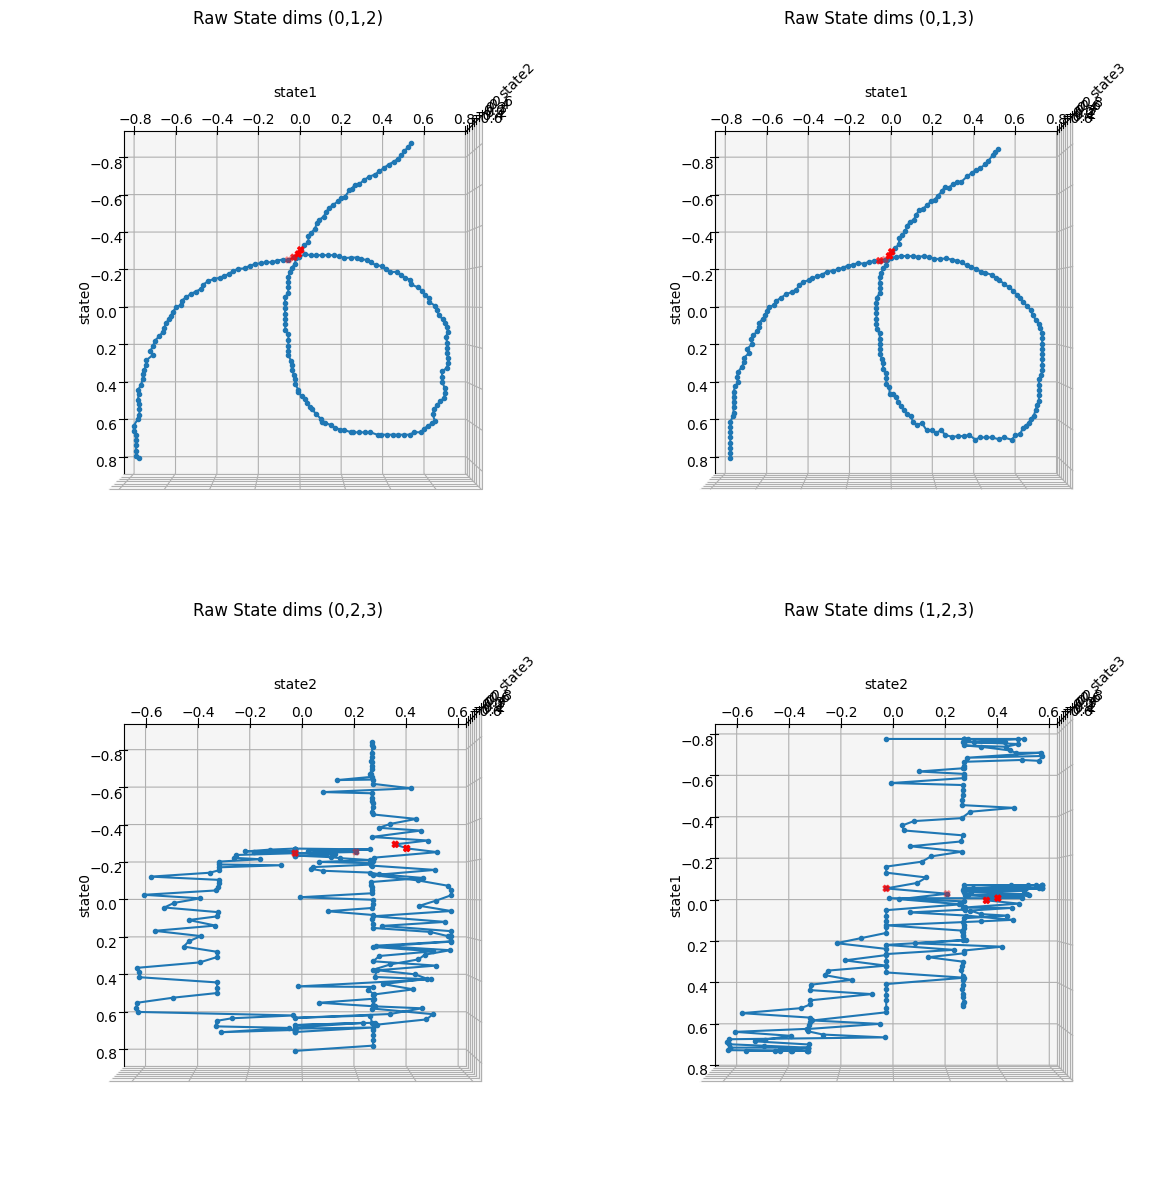

In [184]:
# %% 
# 5. Plot raw state trajectories for the same demo
# 원본 state 차원: dim_state = workspace_dimensions * dynamical_system_order
traj_idx=0
demo=demos[traj_idx]
state_traj = []  # shape: (n_steps, dim_state)
for t in range(n_steps):
    pos = demo[t, :, 0]  # 위치
    if params.dynamical_system_order == 2:
        next_pos = demo[t, :, 1]
        vel = next_pos - pos
        # 정규화(선택 사항; latent와 동일하게 보려면 정규화하세요)
        from submodule.CONDOR.src.agent.utils.dynamical_system_operations import normalize_state
        vel_norm = normalize_state(
            torch.tensor(vel).view(1, dim_ws, 1),
            x_min=torch.tensor(data['vel min train']).view(1, dim_ws, 1),
            x_max=torch.tensor(data['vel max train']).view(1, dim_ws, 1)
        ).squeeze().numpy()
        state_vec = np.concatenate([pos, vel_norm], axis=0)
    else:
        state_vec = pos
    state_traj.append(state_vec)
state_traj = np.stack(state_traj)  # (n_steps, dim_state)

# 6. 3D raw state subplots (first 3 dims of state_vec)
fig = plt.figure(figsize=(12,12))
# we only have dim_state=4 at most, so we can do same 4 combos:
for i, (a,b,c) in enumerate(combinations, 1):
    ax = fig.add_subplot(2,2,i, projection='3d')
    ax.plot(
        state_traj[:, a], 
        state_traj[:, b], 
        state_traj[:, c], 
        marker='o', 
        markersize=3
    )
    ax.scatter(state_traj[mask, a], state_traj[mask, b], state_traj[mask, c],
               c='red', marker='X', s=20, label='special points')
    ax.set_xlabel(f'state{a}')
    ax.set_ylabel(f'state{b}')
    ax.set_zlabel(f'state{c}')
    ax.set_title(f'Raw State dims ({a},{b},{c})')
    ax.view_init(elev=90, azim=0)
plt.tight_layout()
plt.show()


In [181]:
import numpy as np
from sklearn.neighbors import KDTree

def bbox_overlap_nd(Pi, Pi1, Pj, Pj1):
    """ND 바운딩 박스 겹침 여부"""
    D = Pi.shape[0]
    for dim in range(D):
        min_i, max_i = min(Pi[dim], Pi1[dim]), max(Pi[dim], Pi1[dim])
        min_j, max_j = min(Pj[dim], Pj1[dim]), max(Pj[dim], Pj1[dim])
        if max_i < min_j or max_j < min_i:
            return False
    return True

def segments_intersect_nd(Pi, Pi1, Pj, Pj1, tol=1e-8):
    """
    두 ND 선분 [Pi, Pi1], [Pj, Pj1]의 교차 여부 (파라메트릭 최소자승).
    returns: (intersects, t, s, residual_norm)
    """
    di = Pi1 - Pi
    dj = Pj1 - Pj
    D = Pi.shape[0]
    # A: D×2, b: D×1
    A = np.stack([di, -dj], axis=1)    # shape (D,2)
    b = (Pj - Pi).reshape(D, 1)        # shape (D,1)
    sol, residuals, rank, _ = np.linalg.lstsq(A, b, rcond=None)
    t, s = sol.flatten()
    if rank < 2:
        return False, None, None, None
    if residuals.size > 0:
        norm = np.sqrt(residuals[0])
    else:
        res = A.dot(sol) - b
        norm = np.linalg.norm(res)
    intersects = (0 - tol <= t <= 1 + tol and
                  0 - tol <= s <= 1 + tol and
                  norm < tol)
    return intersects, t, s, norm

def has_self_intersection_nd(traj, tol=1):
    """
    traj: ndarray of shape (n_points, D)
    returns: (bool, (i,j), t, s, norm)
    """
    n, D = traj.shape
    mids = np.array([(traj[i] + traj[i+1]) / 2 for i in range(n-1)])
    tree = KDTree(mids)
    for i in range(n-1):
        di = traj[i+1] - traj[i]
        radius = np.linalg.norm(di) * 2
        idxs = tree.query_radius([mids[i]], r=radius)[0]
        for j in idxs:
            if abs(i - j) <= 1 or (i == 0 and j == n-2):
                continue
            if not bbox_overlap_nd(traj[i], traj[i+1], traj[j], traj[j+1]):
                continue
            inter, t, s, norm = segments_intersect_nd(
                traj[i], traj[i+1], traj[j], traj[j+1], tol)
            if inter:
                return True, (i, j), t, s, norm
    return False, None, None, None, None

# === 예시: 100×2 랜덤 데이터로 실행 ===
np.random.seed(0)
traj2d = latent_traj[:,0:2]
intersected, pair, t, s, norm = has_self_intersection_nd(traj2d)
if intersected:
    i, j = pair
    print(f"Self-intersecting at segments ({i},{i+1})↔({j},{j+1})")
    print(f" t={t:.4f}, s={s:.4f}, residual norm={norm:.2e}")
else:
    print("No self-intersection found on 2D trajectory.")


Self-intersecting at segments (3,4)↔(8,9)
 t=0.0630, s=-0.0347, residual norm=0.00e+00


In [182]:
import numpy as np
from sklearn.neighbors import KDTree

def bbox_overlap_nd(Pi, Pi1, Pj, Pj1):
    """Check overlap of axis-aligned bounding boxes in N dimensions."""
    D = Pi.shape[0]
    for dim in range(D):
        min_i, max_i = min(Pi[dim], Pi1[dim]), max(Pi[dim], Pi1[dim])
        min_j, max_j = min(Pj[dim], Pj1[dim]), max(Pj[dim], Pj[dim])
        if max_i < min_j or max_j < min_i:
            return False
    return True

def segments_intersect_nd(Pi, Pi1, Pj, Pj1, tol=1e-8):
    """
    Determine intersection of two N-D segments [Pi, Pi1] and [Pj, Pj1]
    via least-squares parametric solution.
    Returns (intersects: bool, t: float, s: float, residual_norm: float).
    """
    di = Pi1 - Pi
    dj = Pj1 - Pj
    A = np.stack([di, -dj], axis=1)      # shape (D, 2)
    b = (Pj - Pi).reshape(-1, 1)          # shape (D, 1)
    sol, residuals, rank, _ = np.linalg.lstsq(A, b, rcond=None)
    t, s = sol.flatten()
    if rank < 2:
        return False, None, None, None
    if residuals.size > 0:
        norm = np.sqrt(residuals[0])
    else:
        norm = np.linalg.norm(A.dot(sol) - b)
    intersects = ( -tol <= t <= 1+tol and -tol <= s <= 1+tol and norm < tol )
    return intersects, t, s, norm

def find_all_self_intersections_nd(traj, tol=1e-8):
    """
    Find all self-intersecting segment pairs in an N-D trajectory.
    Returns a list of tuples: (i, j, t, s, norm),
    where segments are [traj[i], traj[i+1]] and [traj[j], traj[j+1]].
    """
    n, D = traj.shape
    # Compute midpoints of each segment for spatial indexing
    mids = np.array([(traj[i] + traj[i+1]) / 2 for i in range(n-1)])
    tree = KDTree(mids)
    intersections = []

    for i in range(n-1):
        # search radius: twice the segment length
        radius = np.linalg.norm(traj[i+1] - traj[i]) * 2
        candidates = tree.query_radius([mids[i]], r=radius)[0]

        for j in candidates:
            # skip adjacent segments or first-last wrap
            if abs(i - j) <= 1 or (i == 0 and j == n-2):
                continue
            # bounding-box 빠른 검사
            if not bbox_overlap_nd(traj[i], traj[i+1], traj[j], traj[j+1]):
                continue
            inter, t, s, norm = segments_intersect_nd(
                traj[i], traj[i+1], traj[j], traj[j+1], tol
            )
            if inter:
                intersections.append((i, j, t, s, norm))

    return intersections

# === 예시 실행 ===
if __name__ == "__main__":
    np.random.seed(0)
    # 예시용 2D 궤적: 100개 랜덤 점
    traj2d = state_traj[:,0:2]
    results = find_all_self_intersections_nd(traj2d, tol=1)

    if results:
        print(f"Found {len(results)} self-intersections:")
        for (i, j, t, s, norm) in results:
            print(f" Segments ({i},{i+1}) ↔ ({j},{j+1}): "
                  f"t={t:.4f}, s={s:.4f}, residual_norm={norm:.2e}")
    else:
        print("No self-intersection found on 2D trajectory.")


Found 2 self-intersections:
 Segments (30,31) ↔ (141,142): t=1.6136, s=1.4680, residual_norm=1.10e-17
 Segments (31,32) ↔ (142,143): t=0.5120, s=0.4470, residual_norm=3.88e-18


In [173]:
import numpy as np
from sklearn.neighbors import KDTree

def segment_distance_nd(P0, P1, Q0, Q1):
    """
    Compute the minimum distance between segments P(s)=P0 + s*(P1-P0), s∈[0,1]
    and Q(t)=Q0 + t*(Q1-Q0), t∈[0,1], in N dimensions.
    Returns: (distance, s_clamped, t_clamped)
    """
    u = P1 - P0
    v = Q1 - Q0
    w0 = P0 - Q0

    a = np.dot(u, u)        # |u|^2
    b = np.dot(u, v)
    c = np.dot(v, v)        # |v|^2
    d = np.dot(u, w0)
    e = np.dot(v, w0)

    D = a*c - b*b           # denominator

    # if segments are not parallel, compute unconstrained s,t
    if D > 1e-12:
        s = (b*e - c*d) / D
        t = (a*e - b*d) / D
    else:
        # parallel case: choose s=0, solve t to minimize distance to P0
        s = 0.0
        t = e / c if c > 1e-12 else 0.0

    # clamp s,t to [0,1]
    s_clamped = np.clip(s, 0.0, 1.0)
    t_clamped = np.clip(t, 0.0, 1.0)

    # recompute closest points
    P_closest = P0 + s_clamped * u
    Q_closest = Q0 + t_clamped * v
    dist = np.linalg.norm(P_closest - Q_closest)
    return dist, s_clamped, t_clamped

def all_segments_separated_nd(traj, min_dist, tol=1e-8):
    """
    Check all non-adjacent segment pairs in trajectory traj (shape: [n, D])
    are at least min_dist apart.
    Returns list of violating pairs: [(i, j, dist, s, t), ...].
    """
    n, D = traj.shape
    mids = np.array([(traj[i] + traj[i+1]) / 2 for i in range(n-1)])
    tree = KDTree(mids)
    violations = []

    for i in range(n-1):
        # 후보를 찾기 위한 반경: segment 길이 + min_dist
        seg_len = np.linalg.norm(traj[i+1] - traj[i])
        radius = seg_len + min_dist
        idxs = tree.query_radius([mids[i]], r=radius)[0]

        for j in idxs:
            if abs(i - j) <= 20 or (i == 0 and j == n-2):
                continue

            # 빠른 바운딩 박스 검사 (min_dist 확장)
            Pi, Pi1 = traj[i], traj[i+1]
            Pj, Pj1 = traj[j], traj[j+1]
            for dim in range(D):
                min_i, max_i = sorted((Pi[dim], Pi1[dim]))
                min_j, max_j = sorted((Pj[dim], Pj1[dim]))
                if max_i + min_dist < min_j or max_j + min_dist < min_i:
                    break
            else:
                # 실제 거리 계산
                dist, s, t = segment_distance_nd(Pi, Pi1, Pj, Pj1)
                if dist < min_dist - tol:
                    violations.append((i, j, dist, s, t))

    return violations

# === 사용 예시 ===
if __name__ == "__main__":
    np.random.seed(0)
    traj2d = latent_traj
    # 최소 0.05 이상 떨어져 있어야 한다고 설정
    min_distance = 0.1
    viols = all_segments_separated_nd(traj2d, min_distance)

    if viols:
        print(f"{len(viols)}개의 분리 위반(segment pairs)이 발견되었습니다:")
        for i, j, dist, s, t in viols:
            print(f"  세그먼트 ({i},{i+1})↔({j},{j+1}): 거리가 {dist:.4f}, s={s:.3f}, t={t:.3f}")
    else:
        print(f"모든 세그먼트 쌍이 최소 {min_distance}만큼 분리되어 있습니다.")


75개의 분리 위반(segment pairs)이 발견되었습니다:
  세그먼트 (27,28)↔(74,75): 거리가 0.0845, s=0.534, t=0.000
  세그먼트 (27,28)↔(73,74): 거리가 0.0706, s=0.538, t=0.000
  세그먼트 (27,28)↔(72,73): 거리가 0.0823, s=0.574, t=1.000
  세그먼트 (27,28)↔(71,72): 거리가 0.0759, s=0.535, t=0.657
  세그먼트 (27,28)↔(70,71): 거리가 0.0860, s=0.528, t=0.802
  세그먼트 (27,28)↔(69,70): 거리가 0.0798, s=0.506, t=0.000
  세그먼트 (27,28)↔(68,69): 거리가 0.0946, s=0.540, t=1.000
  세그먼트 (27,28)↔(65,66): 거리가 0.0835, s=0.492, t=1.000
  세그먼트 (27,28)↔(58,59): 거리가 0.0543, s=0.393, t=0.774
  세그먼트 (27,28)↔(67,68): 거리가 0.0602, s=0.487, t=0.000
  세그먼트 (27,28)↔(64,65): 거리가 0.0723, s=0.456, t=0.000
  세그먼트 (27,28)↔(63,64): 거리가 0.0687, s=0.450, t=0.000
  세그먼트 (27,28)↔(62,63): 거리가 0.0871, s=0.408, t=0.000
  세그먼트 (27,28)↔(61,62): 거리가 0.0809, s=0.387, t=0.000
  세그먼트 (27,28)↔(60,61): 거리가 0.0500, s=0.419, t=0.724
  세그먼트 (27,28)↔(66,67): 거리가 0.0602, s=0.488, t=1.000
  세그먼트 (27,28)↔(57,58): 거리가 0.0667, s=0.396, t=1.000
  세그먼트 (27,28)↔(56,57): 거리가 0.0671, s=0.354, t=0.000
  세그먼트 (27